# CNN vs MLP
In this notebook it will be showed how to train a CNN and what are its advantages (and disanvantages) with respect to a fully connected network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

torch.manual_seed(0)

In [2]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Dataset Loading
First step we need to load the dataset that will be used for train and test.

In this case MNIST dataset will be used. MNIST consist in black and white images of handwritten digits between 0-9.

Pytorch Dataloaders will be used for this task.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# TRAIN dataset
# Pytorch already has some datasets available for downlaod

# Mi salvo il dataset all'interno di un oggetto:
train_dataset = datasets.MNIST(
                        '../data', 
                        train=True, 
                        download=True, 
                        # transforms that we want to apply when iterating the dataset
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            # mean and std of MNIST dataset
                            transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# The dataloader will iterate through the dataset and load the data in memory

# Passo l'oggetto contenente il dataset ad un loader:
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, 
                        shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=False)

In [4]:
print(len(train_dataset), len(train_loader)) #WHY?

60000 938


In [5]:
# plotting libs
from res.plot_lib import plot_data, plot_model, set_default
set_default()

ModuleNotFoundError: No module named 'res.plot_lib'

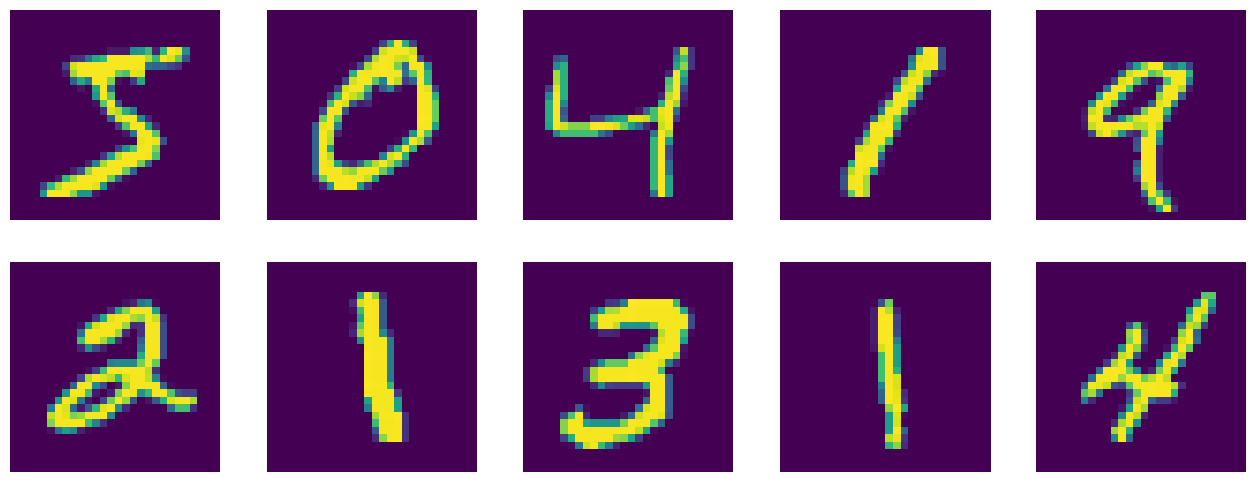

In [6]:
# show some images
def denorm_mnist(x):
    m = 0.1307
    std = 0.3081
    # denormalization operation = std*x + m
    return x*std + m

to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(denorm_mnist(image)))
    plt.axis('off')

## Network Definition
Let's define an MLP and a CNN to solve the MNIST digit classification task.

In [7]:
# MLP
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # flattenizzo l'input x
        return self.network(x)

# CNN
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(n_feature*4*4, 50)
        # Siccome ci sono 10 possibili classi nel dataset, l'ultimo layer avrà 20 neuroni!
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv_block1(x) # what is the output size?
        x = self.conv_block2(x) # what is the output size?
        x = x.view(-1, self.n_feature*4*4) # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # log_softmax perchè le classi sono mutuamente esclusive
        return x

In [8]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# define train and test function
accuracy_list = []
def train(epoch, model, optimizer, perm=None):
    model.train()
    # dataloader will iterate the dataset and return images (data)
    # and labels (target)
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device) #carico data e target sul device
        
        # permute pixels

        # flattenizzo l'immagine, sapendo che è una 28x28
        data = data.view(-1, 28*28)
        # mescolamento dei pixel
        data = data[:, perm]
        # metto a posto le dimensioni del tensor
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=None):
    # metto il modello in evaluation(), così non avviene l'addestramento!!!
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        # qua anzichè definire una lista di test loss usa un accumulatore unico, perchè non dobbiamo ciclare sui batch come durante il tranining
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [11]:
n_hidden = 8 # number of hidden units

# istanzio il modello
model_fnn = FC2Layer(input_size, n_hidden, output_size)
# carico il modello sul device
model_fnn.to(device)
# mi definisco l'optimizer
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331591
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.831978
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.455269
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.048247
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.951796
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.639522
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.454801
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.566064
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.500952
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.281550

Test set: Average loss: 0.4409, Accuracy: 8721/10000 (87%)



In [13]:
# Training settings 
n_features = 6 # number of feature maps


model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298152
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.085728
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.422282
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.464251
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.262715
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.165966
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.170972
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.081582
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.178629
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.353944

Test set: Average loss: 0.1553, Accuracy: 9508/10000 (95%)



The CNN performs much better that an MLP on images.

Now let's try to shuffle the pixels!

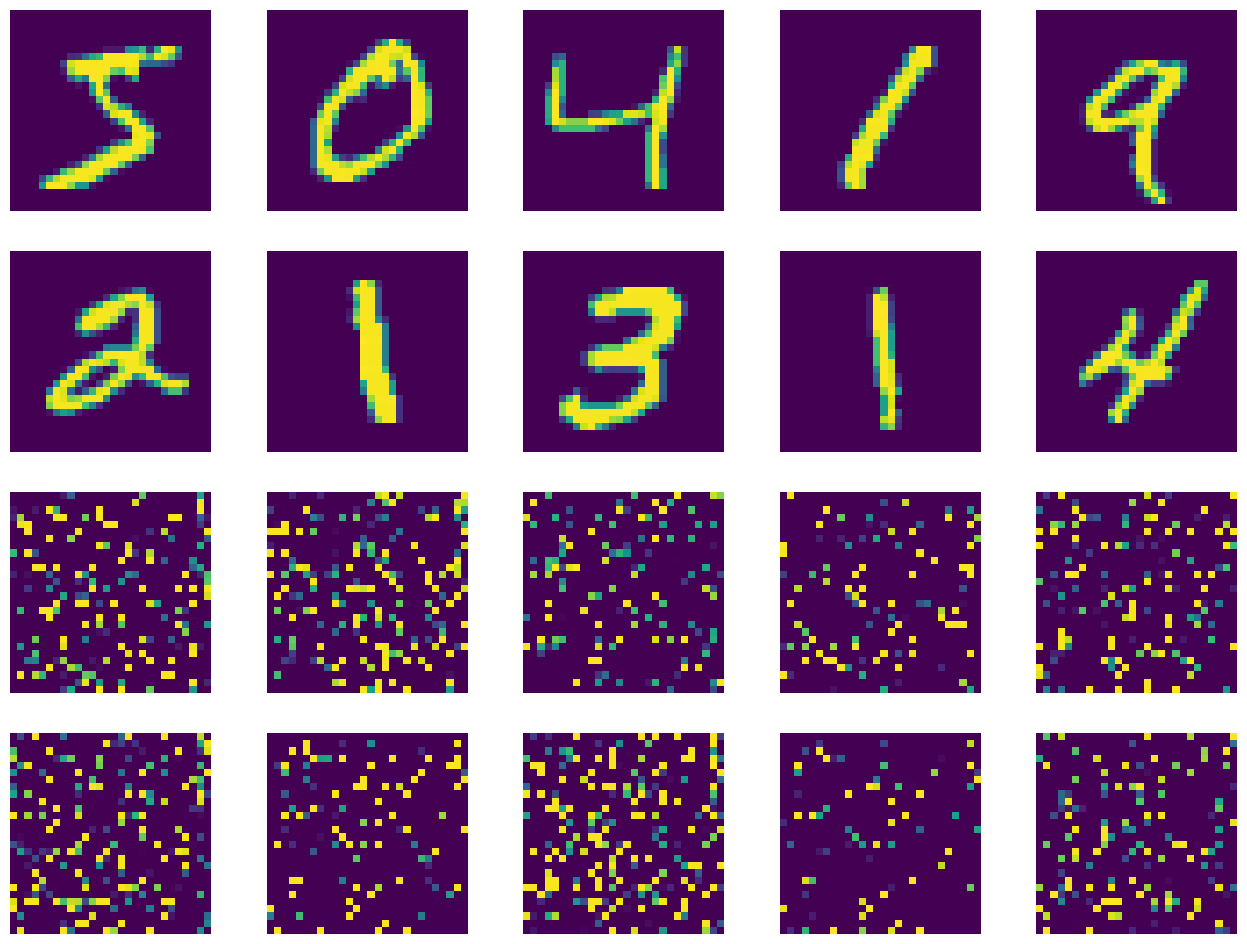

In [14]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(to_pil(denorm_mnist(image.squeeze())))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(to_pil(denorm_mnist(image_perm.squeeze())))
    plt.axis('off')

### How the CNN will perform now?

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303032
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.260589
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.101525
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.497638
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.417548
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.789373
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.651356
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.490145
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.627421
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.826661

Test set: Average loss: 0.5095, Accuracy: 8456/10000 (85%)



### How about the MLP?

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.368797
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.953290
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.692478
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.098868
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.887150
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.623482
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.565358
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.669675
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.437560
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.285761

Test set: Average loss: 0.4758, Accuracy: 8653/10000 (87%)



### The CNN performances dropped!!!
WHY? The concept of locality was lost: pixel are no longer stationary on a grid

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4, color = ['red', 'green', 'green', 'red'])
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
plt.title('Performance comparison')